In [599]:
import numpy as np
import pandas as pd
import os
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVR, SVR, SVC,LinearSVC
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Read in data
df_training_original = pd.read_csv('train_features.csv')
df_training_label = pd.read_csv('train_labels.csv')
all_pids = [pid for pid in df_training_original['pid'].unique()]

In [3]:
def getPatientData(trainingData, pids, patients=0, mode='pid'):
    if mode == 'number':
        pids = all_pids[:patients]
    if len(pids) == 0:
        return trainingData
    #pids = np.array(pids).astype(np.float)
    patients = [trainingData.iloc[idx] for idx in range(0, len(trainingData)) if trainingData['pid'][idx] in pids]    
    #patientTrainingDataIndex = [trainingData.iloc[idx] for idx, col in enumerate(trainingData) if trainingData['pid'][idx] in pids]    
    return pd.DataFrame(patients)

def partitionData(trainingDataPids, trainingPartition=80):
    validationPartition = 100 - trainingPartition
    countTraining = int((trainingPartition/100)*len(trainingDataPids))
    training = trainingDataPids[:countTraining]
    validation = trainingDataPids[countTraining:]
    print('')
    print('Training size: ' + str(countTraining))
    print('Validation size: ' + str(len(validation)))
    return training, validation

def populateData(X,Y):
    Z = pd.merge(X, Y, on='pid')
    YData = Z[Y.columns].iloc[:,1:]
    XData = Z[X.columns].iloc[:,1:]
    return XData, YData

In [4]:
df_training = df_training_original.copy()

# See how many values are missing in which rows
loss = df_training_original.isnull().any()
lossRow = df_training[df_training_original == loss].sum()
print('Number of missing values in data:')
print(lossRow[lossRow > 0].sort_values(ascending=False))

# Filter out certain rows with a lot of missing data
lossColumns = list(lossRow[lossRow > 100].index)
df_training = df_training.drop(columns=lossColumns)

# Set all time data to be between 1-12
X_ALL = pd.DataFrame(columns = df_training.columns)
if os.path.exists('x_time_adjusted.csv'):
    X_ALL = pd.read_csv('x_time_adjusted.csv', index_col=False)
    X_ALL = X_ALL.iloc[:,1:]
else:
    for pids in all_pids:
        df_trainingTemp = df_training[df_training['pid'] == pids]
        df_trainingTemp['Time'] = df_trainingTemp['Time'] - (df_trainingTemp['Time'].min() -1)
        X_ALL = pd.concat([X_ALL, df_trainingTemp])
    
df_training = X_ALL.copy()
# Partition data in training and validation
trainingPIDS, validationPIDS = partitionData(all_pids)


Number of missing values in data:
FiO2                3246.0
BaseExcess          1267.0
Creatinine           837.0
Lactate              295.0
Bilirubin_total      219.0
RRate                101.0
Magnesium             59.0
Phosphate             59.0
Bilirubin_direct      19.0
Calcium               19.0
TroponinI             11.0
BUN                    9.0
WBC                    8.0
dtype: float64

Training size: 15196
Validation size: 3799


In [609]:
## Divide data in half

X_pid_train = pd.DataFrame(columns=['pid','Age', 'Temp1','Temp2','Temp3','Temp4','Temp5','Temp6',
                              'HR1','HR2','HR3','HR4','HR5','HR6',
                              'Abps1','Abps2','Abps3','Abps4','Abps5','Abps6',
                              'ABPm1','ABPm2','ABPm3','ABPm4','ABPm5','ABPm6',
                                    'SpO21','SpO22','SpO23','SpO24','SpO25','SpO26',
                                    'ABPd1','ABPd2','ABPd3','ABPd4','ABPd5','ABPd6'
                                   ])

Y_pid_train = pd.DataFrame(columns = df_training_label.columns)
for pid in all_pids:
    uniqueData = df_training_original[df_training_original['pid']==pid]
    yResult = df_training_label[df_training_label['pid'] == pid]
    yResult['pid'] = yResult['pid'].astype(np.float)
    Temp = uniqueData['Temp']
    #if Temp.isna().sum() > 3:
    #    continue
    HR = uniqueData['Heartrate']
    Abps = uniqueData['ABPs']
    Abpm = uniqueData['ABPm']
    Abpd = uniqueData['ABPd']
    
    spo2 = uniqueData['SpO2']
    pH  = uniqueData['pH']
    DF = pd.DataFrame([[np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan]],
                      columns=['pid','Age', 'Temp1','Temp2','Temp3','Temp4','Temp5','Temp6',
                              'HR1','HR2','HR3','HR4','HR5','HR6',
                              'Abps1','Abps2','Abps3','Abps4','Abps5','Abps6',
                              'ABPm1','ABPm2','ABPm3','ABPm4','ABPm5','ABPm6',
                                    'SpO21','SpO22','SpO23','SpO24','SpO25','SpO26',
                                    'ABPd1','ABPd2','ABPd3','ABPd4','ABPd5','ABPd6'
                                   ])

    DF['pid'] = uniqueData['pid'].iloc[0]
    DF['Age'] = uniqueData['Age'].iloc[0]
    for i in range(0,6):
        DF['Temp' + str(i+1)] = Temp.iloc[2*i]
        DF['HR' + str(i+1)] = HR.iloc[2*i]
        DF['Abps' + str(i+1)] = Abps.iloc[2*i]
        DF['ABPm' + str(i+1)] = Abpm.iloc[2*i]
        DF['SpO2' + str(i+1)] = spo2.iloc[2*i]
        DF['ABPd' + str(i+1)] = Abpd.iloc[2*i]

#        DF['pH' + str(i+1)] = pH.iloc[2*i]

    X_pid_train = pd.concat([X_pid_train, DF])
    Y_pid_train = pd.concat([Y_pid_train, yResult])
print(X_pid_train.shape)


C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(18995, 38)


In [361]:
# Only take every third datapoint

X_pid_train = pd.DataFrame(columns=['pid','Age', 
                                    'Temp1','Temp2','Temp3',
                              'HR1','HR2','HR3',
                              'Abps1','Abps2','Abps3',
                              'ABPm1','ABPm2','ABPm3',
                                    'SpO21','SpO22','SpO23',
                                    'ABPd1','ABPd2','ABPd3'
                                   ])

Y_pid_train = pd.DataFrame(columns = df_training_label.columns)
for pid in all_pids[:100000]:
    uniqueData = df_training_original[df_training_original['pid']==pid]
    yResult = df_training_label[df_training_label['pid'] == pid]
    yResult['pid'] = yResult['pid'].astype(np.float)
    Temp = uniqueData['Temp']
    #if Temp.isna().sum() > 3:
    #    continue
    HR = uniqueData['Heartrate']
    Abps = uniqueData['ABPs']
    Abpm = uniqueData['ABPm']
    Abpd = uniqueData['ABPd']
    spo2 = uniqueData['SpO2']
    #pH  = uniqueData['pH']
    
    DF = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
                        np.nan,np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]],
                      columns=['pid','Age', 
                              'Temp1','Temp2','Temp3',
                              'HR1','HR2','HR3',
                              'Abps1','Abps2','Abps3',
                              'ABPm1','ABPm2','ABPm3',
                              'SpO21','SpO22','SpO23',
                              'ABPd1','ABPd2','ABPd3'])

    DF['pid'] = uniqueData['pid'].iloc[0]
    DF['Age'] = uniqueData['Age'].iloc[0]
    for i, j in enumerate([0,5,11]):
        DF['Temp' + str(i+1)] = Temp.iloc[j]
        DF['HR' + str(i+1)] = HR.iloc[j]
        DF['Abps' + str(i+1)] = Abps.iloc[j]
        DF['ABPm' + str(i+1)] = Abpm.iloc[j]
        DF['SpO2' + str(i+1)] = spo2.iloc[j]
        DF['ABPd' + str(i+1)] = Abpd.iloc[j]

#        DF['pH' + str(i+1)] = pH.iloc[2*i]
    X_pid_train = pd.concat([X_pid_train, DF])
    Y_pid_train = pd.concat([Y_pid_train, yResult])
print(X_pid_train.shape)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(18995, 20)


In [610]:
print(X_pid_train.head())

     pid   Age  Temp1  Temp2  Temp3  Temp4  Temp5  Temp6   HR1    HR2  ...  \
0      1  34.0   36.0   36.0    NaN   37.0    NaN    NaN  94.0   92.0  ...   
0     10  71.0    NaN    NaN   36.0    NaN   36.0    NaN   NaN   83.0  ...   
0    100  68.0   35.0   36.0   36.0    NaN   38.0    NaN  94.0   94.0  ...   
0   1000  79.0    NaN   36.0   36.0   37.0   37.0   38.0   NaN  110.0  ...   
0  10000  76.0    NaN   37.0    NaN    NaN    NaN    NaN   NaN   66.0  ...   

   SpO23  SpO24  SpO25  SpO26  ABPd1  ABPd2  ABPd3  ABPd4  ABPd5  ABPd6  
0  100.0  100.0  100.0  100.0   61.0   59.0   48.0   46.0   47.0   49.0  
0   98.0   98.0   96.0   99.0    NaN   92.0   76.0   73.0   85.0   80.0  
0   97.0   96.0   92.0   97.0   74.0   54.0   65.0   68.0   61.0   64.0  
0   98.0  100.0  100.0  100.0    NaN   63.0   55.5   69.0   65.0   57.0  
0   98.0   99.0   98.0   97.0    NaN   43.0   47.5   51.0   47.0   52.5  

[5 rows x 38 columns]


In [611]:
my_imputer = SimpleImputer(strategy='mean')
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_pid_train))
imputed_X_train_plus.columns = X_pid_train.columns
print(imputed_X_train_plus)

           pid   Age      Temp1      Temp2      Temp3      Temp4      Temp5  \
0          1.0  34.0  36.000000  36.000000  36.835235  37.000000  37.014294   
1         10.0  71.0  36.326348  36.568081  36.000000  36.966159  36.000000   
2        100.0  68.0  35.000000  36.000000  36.000000  36.966159  38.000000   
3       1000.0  79.0  36.326348  36.000000  36.000000  37.000000  37.000000   
4      10000.0  76.0  36.326348  37.000000  36.835235  36.966159  37.014294   
...        ...   ...        ...        ...        ...        ...        ...   
18990   9993.0  80.0  36.326348  36.568081  36.835235  36.966159  37.014294   
18991   9995.0  73.0  36.326348  36.568081  36.000000  36.966159  36.000000   
18992   9996.0  53.0  37.000000  37.000000  36.835235  36.966159  38.000000   
18993   9998.0  89.0  36.326348  36.000000  36.000000  37.000000  37.000000   
18994   9999.0  85.0  36.326348  36.568081  36.835235  36.000000  37.014294   

           Temp6       HR1    HR2  ...       SpO23 

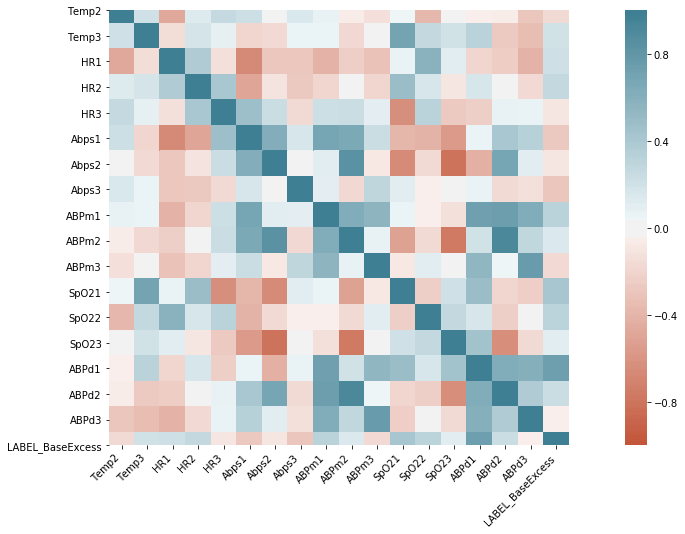

In [612]:
plt.figure(figsize=(20,8))
corr = all_pid_train[all_pid_train.columns[3:31]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [636]:

#regr = LinearSVC(C=1, fit_intercept=False, multi_class='cramer_singer')

# Drop rows that contain 0 for all y targets (get rid of a lot of negatives)
cols = df_training_label.columns
indices = [df_training_label.iloc[x,:].name for x in range(0, len(df_training_label)) if not(df_training_label.iloc[x,1:12] == [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).all()]
df_training2 = df_training_label.loc[indices,:]
X_filtered = imputed_X_train_plus.copy()
X_norm = X_filtered.copy()
X_norm = X_norm[X_norm['pid'].isin(list(df_training2['pid']))]
y_pid_fit = Y_pid_train[Y_pid_train['pid'].isin(list(df_training2['pid']))]
y_pid_fit = y_pid_fit.reset_index(drop=True)

# Normalize the data
X_norm.iloc[:,1:] = StandardScaler().fit_transform(X_norm.iloc[:,1:])
X_norm = pd.DataFrame(X_norm)
X_norm = X_norm.reset_index(drop=True)
X_norm.columns = X_filtered.columns
print(X_norm.shape)



# Train MLPClassifier
#regr =   KNeighborsClassifier(3)
regr = MLPClassifier(alpha=1e-5,hidden_layer_sizes=(100,100), random_state=1, solver='sgd', max_iter=200)
#regr = RidgeClassifierCV()
#regr = RandomForestClassifier()

regr.fit(np.array(X_norm.iloc[:11000,1:]), np.array(y_pid_fit.iloc[:11000,1:11]))


(11129, 38)


C:\Users\Oliver\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [638]:
f = regr.predict_proba(X_norm.iloc[11000:,1:])

f = pd.DataFrame(f)

f.columns = Y_pid_train.columns[1:11]
f['pid'] = X_norm.iloc[11000:,0].reset_index(drop=True)
f['LABEL_Sepsis'] = np.nan
f['LABEL_RRate'] = np.nan
f['LABEL_ABPm'] = np.nan
f['LABEL_SpO2'] = np.nan
f['LABEL_Heartrate'] = np.nan
f = f[Y_pid_train.columns]
get_score(y_pid_fit.iloc[11000:,:], f)

0.6701656409736738

In [ ]:
#mit daten in 3 geteilt 0.6663326701565544 (50,50)
# mit 6 datenpunkten 0.6733103690366024 mit netz (100,100)

In [543]:
import sklearn.metrics as metrics

TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total',
         'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
def get_score(df_true, df_submission):
    df_submission = df_submission.sort_values('pid')
    df_true = df_true.sort_values('pid')
    
    task1 = np.mean([metrics.roc_auc_score(df_true[entry], df_submission[entry]) for entry in TESTS])
    #task2 = metrics.roc_auc_score(df_true['LABEL_Sepsis'], df_submission['LABEL_Sepsis'])
    #task3 = np.mean([0.5 + 0.5 * np.maximum(0, metrics.r2_score(df_true[entry], df_submission[entry])) for entry in VITALS])
    #score = np.mean([task1, task2, task3])
    return task1